In [1]:
import numpy as np

from scipy.spatial.distance import squareform, pdist
from sklearn.manifold import MDS
import matplotlib
import matplotlib.pyplot as plt
SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


In [2]:
# Constants

w = .55

tx = .75
tu = 1.5

a_x = 1. # Stimulus temporal kernel peak amplitude above 1
tau_x = .1 # Stimulus temporal kernel exponential decay
g = lambda u: u + a_x*tau_x*(1. - np.exp(-u/tau_x))

t = np.linspace(0,2,100)
N = len(t)

m = 1. #np.linspace(-1,1)
c = 1. #np.linspace(-1,1)
z = 0.

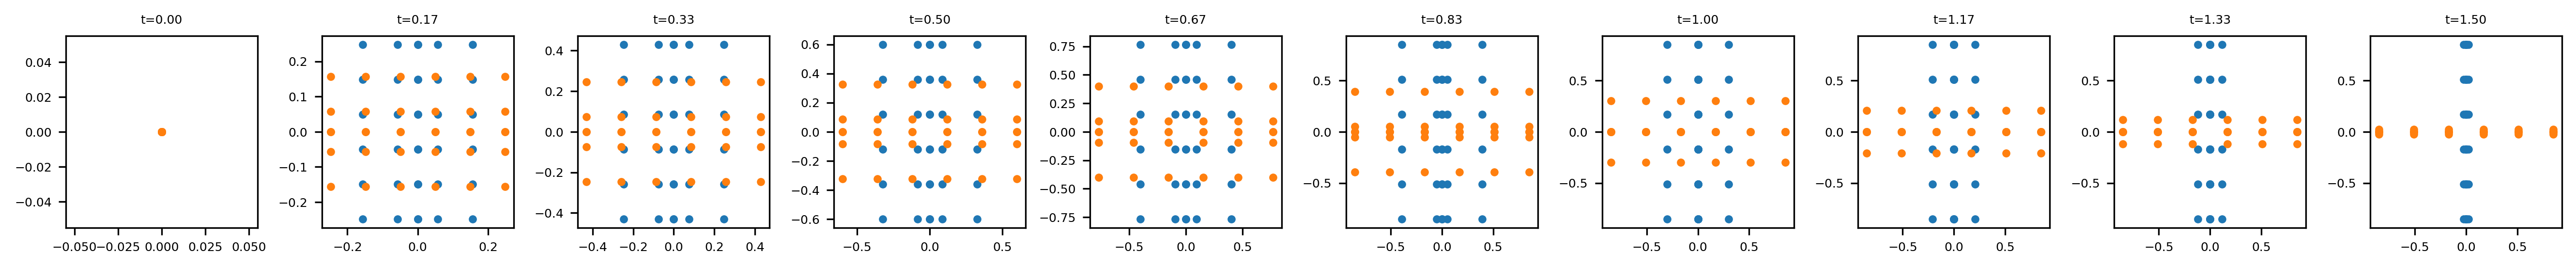

In [3]:


def solutiongrid(m,c,t,tx,tu,w,a_x,tau_x,g):
    h = np.zeros((4,m.shape[0],m.shape[1]))
    
    if t <= tx:
        h[0] = np.maximum( m*g(t) - w*(1-z)*t, 0)
        h[1] = np.maximum(-m*g(t) - w*(1-z)*t, 0)
        h[2] = np.maximum( c*g(t) - w*z*t, 0)
        h[3] = np.maximum(-c*g(t) - w*z*t, 0)
    elif (tx < t) & (t <= tu):
        h[0] = np.maximum( m*g(tx) - w*(1.-z)*t, 0)
        h[1] = np.maximum(-m*g(tx) - w*(1.-z)*t, 0)
        h[2] = np.maximum( c*g(tx) - w*z*t, 0)
        h[3] = np.maximum(-c*g(tx) - w*z*t, 0)
    else:
        h[0] = np.maximum( m*g(tx) - w*(1-z)*tu,0)
        h[1] = np.maximum(-m*g(tx) - w*z*tu,0)
        h[2] = np.maximum( c*g(tx) - w*z*tu,0)
        h[3] = np.maximum(-c*g(tx) - w*z*tu,0)
    return h


ts = np.linspace(0,1.5,10)
zs = np.array([0, 1])
m = np.linspace(-1,1,6)
c = np.linspace(-1,1,6)

mm = 1/25.4
f, axs = plt.subplots(1,ts.shape[0],figsize=(450*mm,50*mm),dpi=300)

for i,ti in enumerate(ts):
    for z in zs:
        mg, cg = np.meshgrid(m,c)
        h = solutiongrid(mg,cg,ti,tx,tu,w,a_x,tau_x,g)

        y1 = (h[0]-h[1]).flatten()
        y2 = (h[2]-h[3]).flatten()
        axs[i].plot(y1,y2,'.')      

        axs[i].set(title=f't={ti:.2f}')
        axs[i].set_aspect('equal', adjustable='box')
f.tight_layout()
f.savefig('2d-timecourse.pdf')


In [4]:
%matplotlib qt
bin1 = np.linspace(0.001,0.2173,217)+0.1
bin2 = np.linspace(0.2173,0.4336,217)+0.1
bin3 = np.linspace(0.4336,0.651,217)+0.1

bins = [bin1, bin2 , bin3]
plt.figure(figsize=(3,8),dpi=300)
for ii,tbin in enumerate(bins):    
    print(ii)
    rdms = []
    ys = []
    for i,ti in enumerate(tbin):    
        y = []
        for iz,z in enumerate(zs):
            mg, cg = np.meshgrid(m,c)
            h = solutiongrid(mg,cg,ti,tx,tu,w,a_x,tau_x,g)

            y1 = (h[0]-h[1]).flatten()
            y2 = (h[2]-h[3]).flatten()
            yt = np.stack((y1,y2),axis=1)
            y = np.concatenate((y,yt),axis=0) if len(y) else yt
        rdms.append(squareform(pdist(y)))
        ys.append(y)
    plt.subplot(3,3,ii+1)
    rdms = np.asarray(rdms)    
    rdm = rdms.mean(0)
    plt.imshow(rdm)
    
    plt.subplot(3,3,ii+4)    
    ys = np.asarray(ys)
    y = ys.mean(0)
    plt.plot(y[:36,0],y[:36,1],'.',markersize=1)
    plt.plot(y[36:,0],y[36:,1],'.',markersize=1)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    plt.subplot(3,3,ii+7)    
    mds = MDS(n_components=2,max_iter=1000,dissimilarity='precomputed')
    y = mds.fit_transform(rdms.mean(0))
    plt.plot(y[:36,0],y[:36,1],'.',markersize=1)
    plt.plot(y[36:,0],y[36:,1],'.',markersize=1)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
plt.tight_layout()


0
1
2


## MDS of RNN activity for early, middle and late time intervals within a trial

In [5]:
from plotting import plot_MDS_embeddings_2D, rotate_axes, rotate
from sklearn.manifold import MDS

In [9]:
# compute RDMs
bin1 = np.linspace(0.001,0.2173,217)+0.1
bin2 = np.linspace(0.2173,0.4336,217)+0.1
bin3 = np.linspace(0.4336,0.651,217)+0.1
bins = [bin1, bin2 , bin3]
all_rdms = []
all_ys = []
for ii,tbin in enumerate(bins):    
    print(ii)
    rdms = []
    ys = []
    for i,ti in enumerate(tbin):    
        y = []
        for iz,z in enumerate(zs):
            mg, cg = np.meshgrid(m,c)
            h = solutiongrid(mg,cg,ti,tx,tu,w,a_x,tau_x,g)

            y1 = (h[0]-h[1]).flatten()
            y2 = (h[2]-h[3]).flatten()
            yt = np.stack((y1,y2),axis=1)
            y = np.concatenate((y,yt),axis=0) if len(y) else yt
        rdms.append(squareform(pdist(y)))
        ys.append(y)    
    rdms = np.asarray(rdms) 
    all_rdms.append(rdms)
    all_ys.append(np.asarray(ys))


0
1
2


In [25]:
# mds is redundant, let's plot RNN activity directly
for ibin in range(3):
    y = all_ys[ibin].mean(0)
    # add dummy dimension 
    xyz = np.zeros((72,3))
    xyz[:,:2] = y
    xyz[:,2] = y[:,1]
    mm = 1/25.4
    fig = plt.figure(ibin+1,figsize=(180*mm, 60*mm), dpi=300, facecolor='w', edgecolor='k')
    plot_MDS_embeddings_2D(xyz,fig,fig_id=ibin+1,axlims=None,flipdims=True,monk=True)

In [66]:
N = len(t)

m = 1. #np.linspace(-1,1)
c = 1. #np.linspace(-1,1)
z = 1.


# Piecewise solutions
h = np.zeros((4,N))
h[0,(t>0) & (t<=tx)] = np.maximum(m*g(t[(t>0) & (t<=tx)]) - w*(1-z)*t[(t>0) & (t<=tx)],0.)
h[0,(t>tx) & (t<=tu)] = np.maximum(m*g(tx) - w*(1.-z)*t[(t>tx) & (t<=tu)],0.)
h[0,t>tu] = np.maximum(m*g(tx)  - w*(1-z)*tu,0)

h[1,(t>0) & (t<=tx)] = np.maximum(-m*g(t[(t>0) & (t<=tx)]) - w*(1-z)*t[(t>0) & (t<=tx)],0.)
h[1,(t>tx) & (t<=tu)] = np.maximum(-m*g(tx)  - w*(1.-z)*t[(t>tx) & (t<=tu)],0.)
h[1,t>tu] = np.maximum(-m*g(tx) - w*z*tu,0)

h[2,(t>0) & (t<=tx)] = np.maximum(c*g(t[(t>0) & (t<=tx)]) - w*z*t[(t>0) & (t<=tx)],0.)
h[2,(t>tx) & (t<=tu)] = np.maximum(c*g(tx)  - w*z*t[(t>tx) & (t<=tu)],0.)
h[2,t>tu] = np.maximum(c*g(tx) - w*z*tu,0)

h[3,(t>0) & (t<=tx)] = np.maximum(-c*g(t[(t>0) & (t<=tx)]) - w*z*t[(t>0) & (t<=tx)],0.)
h[3,(t>tx) & (t<=tu)] = np.maximum(-c*g(tx) - w*z*t[(t>tx) & (t<=tu)],0.)
h[3,t>tu] = np.maximum(-c*g(tx)- w*z*tu,0)

Wr = np.array([1, -1, 1, -1])

r = np.dot(Wr,h)

mm = 1/25.4
f, axs = plt.subplots(2,2,figsize=(90*mm,60*mm),dpi=300)


# Plot inputs
axs[0,0].plot(t,(1+a_x*np.exp(-t/tau_x))*((t>=0)&(t<=tx)).astype(float),t,(t>=0)&(t<=tu),linewidth=1)#plot(t,(t>=0)&(t<=tx),t,(t>=0)&(t<=tu))
axs[0,0].set(ylim=(-0.1,2), xlabel='t (s)', ylabel='Activity',title='Trial Structure')
axs[0,0].legend(['Stim','Context'],frameon=False)
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)

# Plot dynamics
axs[0,1].plot(t,h.T,linewidth=1)
axs[0,1].set(xlabel='t (s)', ylabel='Activity',title='Network Dynamics')
axs[0,1].legend(['h^m+','h^m-','h^c+','h^c-'],frameon=False)
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].plot([0.75,0.75],axs[0,1].get_ylim(),'k--',linewidth=1)

# Plot output
axs[1,0].plot(t,r,linewidth=1)
axs[1,0].set(xlabel='t (s)',ylabel='Response',title='Output')
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].plot([0.75,0.75],axs[1,0].get_ylim(),'k--',linewidth=1)

# Plot aspect ratio
axs[1,1].plot(t,(h[2,:]/(h[0,:])),linewidth=1)
axs[1,1].set(xlabel='t (s)',ylabel='Aspect Ratio',title='Aspect Ratio (Irrel Dim / Rel Dim)')
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].plot([0.75,0.75],axs[1,1].get_ylim(),'k--',linewidth=1)


f.tight_layout()

# f.savefig('compression-timecourse.pdf')

<ipython-input-66-3e202312c983>:57: RuntimeWarning: invalid value encountered in true_divide
  axs[1,1].plot(t,(h[2,:]/(h[0,:])),linewidth=1)
